This is another example of deploying a CNN, this time on a subset of the Kasthuri data set.  This example is essentially the same as that for ISBI 2012, with a few cosmetic differences.  This script assumes you have already run the kast-train-{synapse,membranes}.py scripts to train the CNN weights.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os, os.path, copy, logging, socket, time

import numpy as np
import pylab as plt

#from ndparse.algorithms import nddl as nddl
#import ndparse as ndp
sys.path.append('..'); import ndparse as ndp

try:
    logger
except:
    # do this precisely once
    logger = logging.getLogger("deploy_kast")
    logger.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setFormatter(logging.Formatter('[%(asctime)s:%(name)s:%(levelname)s]  %(message)s'))
    logger.addHandler(ch)

Test data shape is: (100, 1, 1024, 1024)


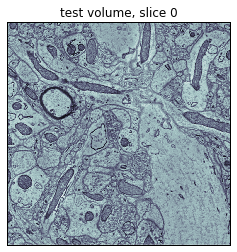

In [2]:
# note: the weight files choosen here are arbitrary.
w_membrane = os.path.join('membrane_weights', 'weights_epoch_001.h5') 
w_synapse = os.path.join('synapse_weights', 'weights_epoch_014.h5')

# load data (from local file - can replace with ndio call if desired)
data = np.load('deep_learning_kasthuri_example_data.npz')
X = data['Xtest']
X = np.transpose(X, [2, 0, 1]).astype(np.float32)
X = X[:,np.newaxis,:,:]

  
# show some details.  Note that data tensors are assumed to have dimensions:
#   (#slices, #channels, #rows, #columns)
#
print('Test data shape is: %s' % str(X.shape))
plt.imshow(X[0,0,...], interpolation='none', cmap='bone')
plt.title('test volume, slice 0')
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
plt.show()

In [ ]:
# In the interest of time, only deploy on one slice (z-dimension) of the test volume 
# *and* only evaluate a subset of the pixels in that slice.
#
# Note: depending upon your system (e.g. CPU vs GPU) this may take a few minutes...
#
tic = time.time()
P_membrane_0 = ndp.nddl.fit(X, w_membrane, slices=[0,], evalPct=.2, log=logger)
print("Time to deploy: %0.2f sec" % (time.time() - tic))

# The shape of the probability estimate tensor is:
#    (#slices, #classes, #rows, #cols)
print('Class probabilities shape: %s' % str(P_membrane_0.shape))

[2016-11-08 22:01:26,936:deploy_kast:WARNING]  No output file specified - are you sure this is what you want?
[2016-11-08 22:01:26,982:deploy_kast:INFO]  X volume dimensions: (1, 1, 1024, 1024)
[2016-11-08 22:01:26,989:deploy_kast:INFO]  X values min/max:    0, 1
[2016-11-08 22:01:26,992:deploy_kast:INFO]  initializing CNN...
[2016-11-08 22:01:27,759:deploy_kast:INFO]  evaluating volume...
[2016-11-08 22:01:32,291:deploy_kast:INFO]  after masking, will evaluate 20.00% of data
[2016-11-08 22:01:33,825:deploy_kast:INFO]    last pixel [  0   0 494] (0.05% complete)


In [ ]:
# Use a simple interpolation scheme to fill in "missing" values 
# (i.e. those pixels we did not evaluate using the CNN).
# 
P_membrane_int_0 = ndp.nddl.interpolate_nn(P_membrane_0)

# visualize
plt.imshow(P_membrane_0[0,0,...]); plt.colorbar()
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
plt.title('Class Estimates (slice 0, subsampled)')
plt.show()

plt.imshow(P_membrane_int_0[0,0,...]); plt.colorbar()
plt.title('Class Estimates: (slice 0, interpolated)')
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
plt.show()


In [5]:

tic = time.time()
P_synapse_0 = ndp.nddl.fit(X, w_synapse, slices=[0,], evalPct=.1, log=logger)
print("Time to deploy (synapse): %0.2f sec" % (time.time() - tic))

# The shape of the probability estimate tensor is:
#    (#slices, #classes, #rows, #cols)
print('Class probabilities shape: %s' % str(P_synapse_0.shape))

[2016-11-08 21:43:24,252:deploy_kast:WARNING]  No output file specified - are you sure this is what you want?
[2016-11-08 21:43:24,294:deploy_kast:INFO]  X volume dimensions: (1, 1, 1024, 1024)
[2016-11-08 21:43:24,296:deploy_kast:INFO]  X values min/max:    0, 1
[2016-11-08 21:43:24,297:deploy_kast:INFO]  initializing CNN...
[2016-11-08 21:43:24,449:deploy_kast:INFO]  evaluating volume...
[2016-11-08 21:43:26,304:deploy_kast:INFO]  after masking, will evaluate 10.00% of data
[2016-11-08 21:43:28,204:deploy_kast:INFO]    last pixel [  0   0 989] (0.10% complete)
[2016-11-08 21:45:28,328:deploy_kast:INFO]    last pixel [  0 209 967] (20.50% complete)
[2016-11-08 21:47:28,716:deploy_kast:INFO]    last pixel [  0 432 628] (42.25% complete)
[2016-11-08 21:49:29,009:deploy_kast:INFO]    last pixel [  0 655 264] (63.99% complete)
[2016-11-08 21:51:29,364:deploy_kast:INFO]    last pixel [  0 877 952] (85.74% complete)
[2016-11-08 21:52:56,962:deploy_kast:INFO]  Complete!


Time to deploy (synapse): 572.71 sec
Class probabilities shape: (1, 2, 1024, 1024)


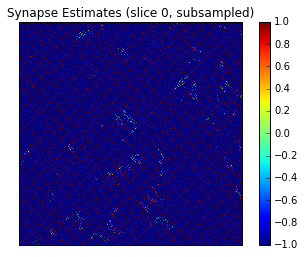

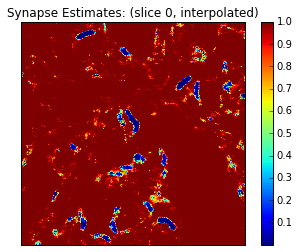

In [6]:
# Use a simple interpolation scheme to fill in "missing" values 
# (i.e. those pixels we did not evaluate using the CNN).
# 
P_synapse_int_0 = ndp.nddl.interpolate_nn(P_synapse_0)

# visualize
plt.imshow(P_synapse_0[0,0,...]); plt.colorbar()
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
plt.title('Synapse Estimates (slice 0, subsampled)')
plt.show()

plt.imshow(P_synapse_int_0[0,0,...]); plt.colorbar()
plt.title('Synapse Estimates: (slice 0, interpolated)')
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
plt.show()
